In [1]:
import os
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pylab import *
from PIL import Image
from copy import deepcopy
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

# 数据

## 数据预览

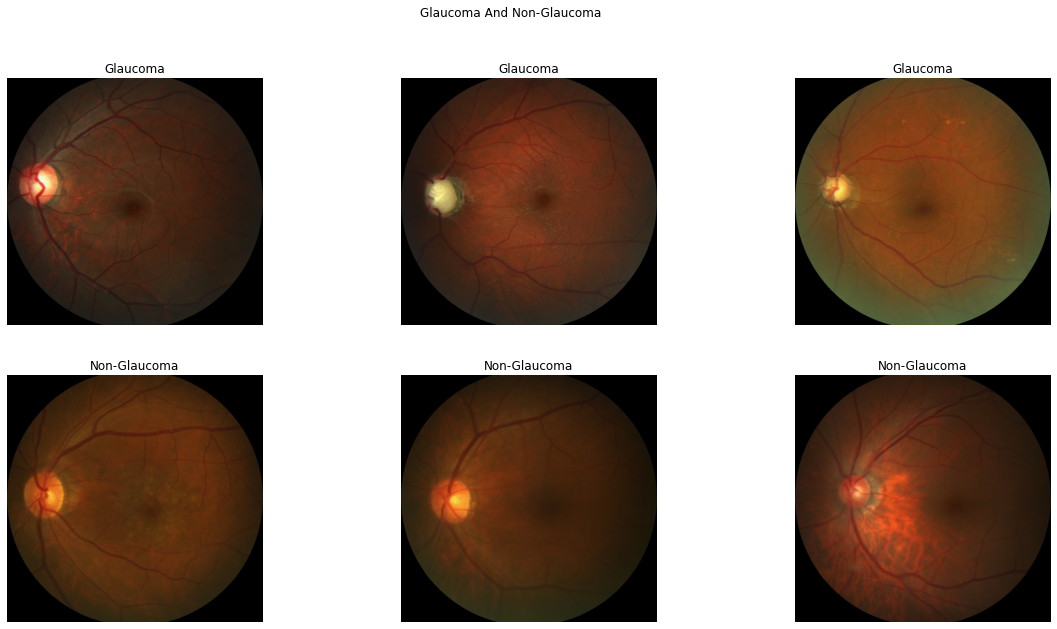

In [2]:
image1 = Image.open("Datasets/Training400/train/Glaucoma/g0001.jpg")
image2 = Image.open("Datasets/Training400/train/Glaucoma/g0002.jpg")
image3 = Image.open("Datasets/Training400/train/Glaucoma/g0003.jpg")
image4 = Image.open("Datasets/Training400/train/Non-Glaucoma/n0001.jpg")
image5 = Image.open("Datasets/Training400/train/Non-Glaucoma/n0002.jpg")
image6 = Image.open("Datasets/Training400/train/Non-Glaucoma/n0003.jpg")

plt.figure(figsize=(20,10)) #设置窗口大小
plt.suptitle('Glaucoma And Non-Glaucoma')
plt.subplot(2,3,1)
plt.title('Glaucoma')
plt.imshow(image1)
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Glaucoma')
plt.imshow(image2)
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Glaucoma')
plt.imshow(image3)
plt.axis('off')

plt.subplot(2,3,4)
plt.title('Non-Glaucoma')
plt.imshow(image4)
plt.axis('off')

plt.subplot(2,3,5)
plt.title('Non-Glaucoma')
plt.imshow(image5)
plt.axis('off')

plt.subplot(2,3,6)
plt.title('Non-Glaucoma')
plt.imshow(image6)
plt.axis('off')

plt.show()

## 数据读取

In [3]:
# 数据增强和标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'E:\Glaucoma\Datasets\Training400'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 模型

## 模型训练与验证

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())

    epoch_losses = []
    epoch_acces = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # 每个 epoch 都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播与优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            epoch_losses.append(epoch_loss)
            epoch_acces.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
        torch.save(model, f'weights/model-{epoch + 1}.pkl')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_acces

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(f"outputs = {outputs}")
            _, preds = torch.max(outputs, 1)
            print(f"preds = {preds}")

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"predicted: {class_names[preds[j]]}, targets={'Non-Glaucoma' if labels[j] == 1 else 'Glaucoma'}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## 模型训练

In [7]:
def train(model_ft, num_epochs):
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft, epoch_losses, epoch_acces = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

    plt.figure(figsize=(10,5))
    plt.title("Loss And Accuracy")
    plt.plot(epoch_losses, label="loss")
    plt.plot(epoch_acces, label="accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Loss And Accuracy")
    plt.legend()
    plt.show()

Epoch 1/2
train Loss: 0.0750 Acc: 0.9866
val Loss: 2.5125 Acc: 0.5000

Epoch 2/2
train Loss: 0.0630 Acc: 0.9888
val Loss: 1.8303 Acc: 0.5000

Training complete in 2m 21s
Best val Acc: 0.500000


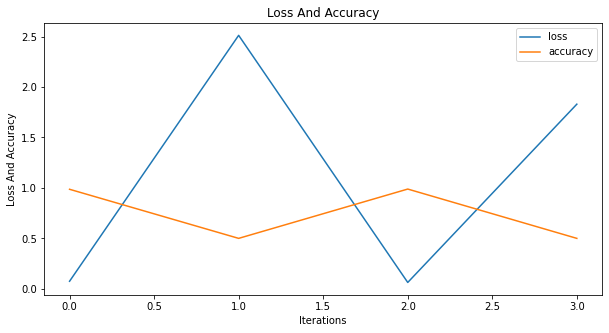

NameError: name 'model' is not defined

In [10]:
train(models.resnet18(), 2)
visualize_model(model)
plt.ioff()
plt.show()

In [9]:
train(models.googlenet(), 2)
visualize_model(model)
plt.ioff()
plt.show()

D:\Anaconda3\lib\site-packages\torchvision\models\googlenet.py:73: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Epoch 1/2


TypeError: max() received an invalid combination of arguments - got (GoogLeNetOutputs, int), but expected one of:
 * (Tensor input)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
